# Titanic - Machine Learning from Disaster

**Nikhil Sharma**

## 1. Introduction:

The sinking of the Titanic is one of the most infamous shipwrecks in history.

On April 15, 1912, during her maiden voyage, the widely considered “ unsinkable ” RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone on-board, resulting in the death of 1502 out of 2224 passengers and crew.

While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others.

In this challenge, we ask you to build a predictive model that answers the question: “ what sorts of people were more likely to survive? ” using passenger data (i.e. name, age, gender, socio-economic class, etc).

## 2. Data and Goal Understanding:

We'll gain access to two similar datasets that include passenger information like name, age, gender, socio-economic class, etc. One dataset is titled `train.csv` and the other is titled `test.csv`.

`Train.csv` will contain the details of a subset of the passengers on board (891 to be exact) and importantly, will reveal whether they survived or not, also known as the “ground truth”. The training set should be used to build our machine learning models. For the training set, we have the outcome (also known as the “ground truth”) for each passenger. Your model will be based on “features” like passengers’ gender and class. You can also use feature engineering to create new features.

The `test.csv` dataset contains similar information but does not disclose the “ground truth” for each passenger. It’s our job to predict these outcomes. The test set should be used to see how well your model performs on unseen data. Our job is to predict these outcomes. For each passenger in the test set, use the model you trained to predict whether or not they survived the sinking of the Titanic.

**Variable Notes :**
* `pclass`: A proxy for socio-economic status (SES)
* 1st = Upper
* 2nd = Middle
* 3rd = Lower
<br>
<br>
* age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5
* sibsp: The dataset defines family relations in this way...
* Sibling = brother, sister, stepbrother, stepsister
* Spouse = husband, wife (mistresses and fiancés were ignored)
* parch: The dataset defines family relations in this way...
* Parent = mother, father
* Child = daughter, son, stepdaughter, stepson
* Some children traveled only with a nanny, therefore parch=0 for them.

**Our Objective - Using the patterns we found in the `train.csv` data,we will predict whether the other 418 passengers on board (found in `test.csv`) survived or not.**

## 3. Data Preparation

### 3.1 Importing Required Libraries :

In [1]:
#make sure you have installed the libraries before importing them.

#Basic Analytical libraries
import numpy as np
import pandas as pd
import scipy.stats as st 
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

#imblearn libraries for balancing our data
import imblearn
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

#Different classification model's libraries
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier

#Libraries for data preprocessing, Imputing, scaling, and splitting the data.
from sklearn.preprocessing import OneHotEncoder,StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, learning_curve


#Libraries for different metrics
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support, confusion_matrix, precision_score, recall_score, roc_auc_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn import metrics

#Libraries for Hyperparameter tuning, feature selection, and importances. 
from sklearn.inspection import permutation_importance
from sklearn.model_selection import GridSearchCV, cross_val_score
from collections import Counter
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.cluster import KMeans

Suppress Warnings

In [2]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

### 3.2 Loading the Data :

In [3]:
test_df = pd.read_csv('data/test.csv')
train_df = pd.read_csv('data/train.csv')

In [4]:
train_df.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


In [5]:
test_df.head(2)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S


### 3.3 Defining useful functions :
* Before we continue with more imbalanced classification scenarios, let's define some utility methods for you to simplify this lab and increase notebook readability.

A method to display basic information for our Dataframe

In [6]:
def df_info(df):   #function to show information about data
    print('Shape of the Dataframe: '.center(60,'-'))
    display(df.shape)
            
    print('Top 5 rows of the Dataframe'.center(60,'-'))
    display(df.head())
    
    print('Bottom 5 rows of the Dataframe'.center(60,'-'))
    display(df.tail())
    
    print('Info of the Dataframe'.center(60,'-')+'\n')
    display(df.info())
    
    print('Description of the data in the DataFrame'.center(60,'-'))
    display(df.describe().T)
  

A method for checking Null and Duplicated values

In [7]:
#defining a function to check that data have null and duplicated values or not

def check_null_duplicated(df):
    print('Number of null values'.center(60,'-'))
    print(df.isnull().sum())
    print(60*'-')
    print('\n'+'Number of duplicated values'.center(60,'-')+'\n')
    print(f'Duplicated Values - {df.duplicated().sum()}')
    print(60*'-')

### 3.4 Exploratory Data Analysis:

In [8]:
df_info(train_df)

------------------Shape of the Dataframe: ------------------


(891, 12)

----------------Top 5 rows of the Dataframe-----------------


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


---------------Bottom 5 rows of the Dataframe---------------


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q


-------------------Info of the Dataframe--------------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


None

----------Description of the data in the DataFrame----------


,count,mean,std,min,25%,50%,75%,max
PassengerId,891.0,446.000000,257.353842,1.00,223.5000,446.0000,668.5,891.0000
Survived,891.0,0.383838,0.486592,0.00,0.0000,0.0000,1.0,1.0000
Pclass,891.0,2.308642,0.836071,1.00,2.0000,3.0000,3.0,3.0000
Age,714.0,29.699118,14.526497,0.42,20.1250,28.0000,38.0,80.0000
SibSp,891.0,0.523008,1.102743,0.00,0.0000,0.0000,1.0,8.0000
Parch,891.0,0.381594,0.806057,0.00,0.0000,0.0000,0.0,6.0000
Fare,891.0,32.204208,49.693429,0.00,7.9104,14.4542,31.0,512.3292


In [9]:
check_null_duplicated(train_df)

-------------------Number of null values--------------------
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
------------------------------------------------------------

----------------Number of duplicated values-----------------

Duplicated Values - 0
------------------------------------------------------------


Few Findings:

* Some features need imputation.
* `Cabin` feature has a lot of missing values, we will use the available values to create a new feature and we will drop the `Cabin` feature.
* We will create the feature `Deck_level`, using the correlation between `Pclass` and info deducted from `Cabin` feature. We suppose that the `Deck_level` could take a role in survivability of the people as the lifeboats were on the top of the deck level.
* From `Name` feature we will split the `LastName` and `Title` and create their respective features and we will use it during creation of `Deck_level`.
* `Age` feature has null values, so we will choose a median value while imputing it by new feature we created `Title`.


#### 3.4.1 Unprocessed Correlation of Data

In [10]:
train_df.corr()['Survived'].sort_values(ascending=False)

Survived       1.000000
Fare           0.257307
Parch          0.081629
PassengerId   -0.005007
SibSp         -0.035322
Age           -0.077221
Pclass        -0.338481
Name: Survived, dtype: float64

Few Findings:
* `Fare` and `Pclass` have the highest correlation to `Survived`, it seams higher class (also higher Fare) had priority to embark the lifeboats.
* `Pclass` has negative correlation because `Pclass` is numbered 1 = High, 2 = Medium, 3 = Low, but results to an inverse survivability (class 3 = lower chance to survive, class 1 = higher chance).

#### 3.4.2 Data Processing

In [11]:
# Separate test_df PassengerId
test_pass_id = test_df.pop('PassengerId')

# Keep max index that will be used to back split training and test data
X_max_index = train_df.shape[0]
print('X-Max_Index = ', X_max_index)

# Separate features and target
y = train_df.Survived

new_df = train_df.drop(['Survived', 'PassengerId'], axis=1)
new_df = pd.concat([new_df, test_df], axis=0).reset_index(drop=True)

new_df.info()

X-Max_Index =  891
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    1309 non-null   int64  
 1   Name      1309 non-null   object 
 2   Sex       1309 non-null   object 
 3   Age       1046 non-null   float64
 4   SibSp     1309 non-null   int64  
 5   Parch     1309 non-null   int64  
 6   Ticket    1309 non-null   object 
 7   Fare      1308 non-null   float64
 8   Cabin     295 non-null    object 
 9   Embarked  1307 non-null   object 
dtypes: float64(2), int64(3), object(5)
memory usage: 102.4+ KB


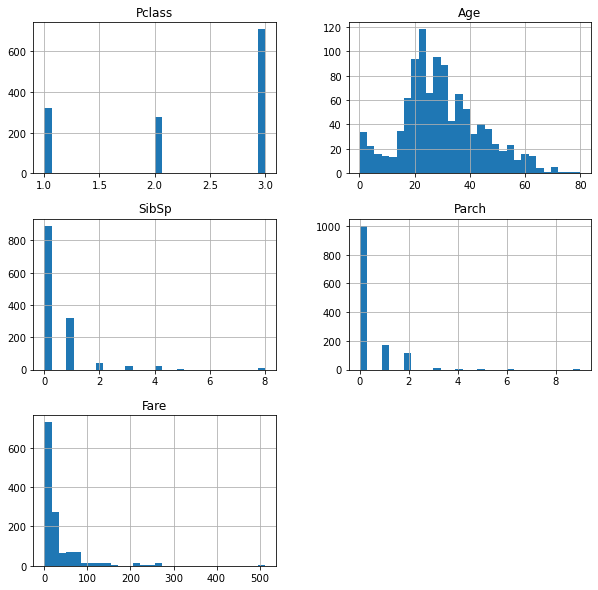

In [12]:
#Feature Instances
new_df.hist(bins=30, figsize=(10,10))
plt.show()

Few Findings:
* Attributes have different scales
* Some features are skewed right, we should check for outliers and normalize data
* `Fare` has values of 0 that looks weird.

In [13]:
# Zero values in Fare we will consider as an error or outlier and will delete for further imputation
new_df.loc[new_df.Fare.eq(0), 'Fare'] = np.nan

Creating `LastName` and `Title` Features

In [14]:
#Exctracting the Last Name from name feature
new_df['Lastname'] = new_df.Name.str.split(', ').str[0]

In [15]:
# Extracting the Title from Name feature
new_df['Title'] = new_df.Name.str.split(', ').str[1]
new_df['Title'] = new_df.Title.str.split('.').str[0]

In [16]:
# Analyze titles
new_df.Title.value_counts()

Mr              757
Miss            260
Mrs             197
Master           61
Rev               8
Dr                8
Col               4
Mlle              2
Major             2
Ms                2
Lady              1
Sir               1
Mme               1
Don               1
Capt              1
the Countess      1
Jonkheer          1
Dona              1
Name: Title, dtype: int64

Few Findings:
* There are some title with the same meaning that should be joined together and also many unique titles that we will group under the title 'Noble'


Analyze the `Title` = `Mr` & `Master` with respective to `Age`

In [17]:
new_df[new_df.Title.eq('Mr')].Age.describe()

count    581.000000
mean      32.252151
std       12.422089
min       11.000000
25%       23.000000
50%       29.000000
75%       39.000000
max       80.000000
Name: Age, dtype: float64

In [18]:
new_df[new_df.Title.eq('Master')].Age.describe()

count    53.000000
mean      5.482642
std       4.161554
min       0.330000
25%       2.000000
50%       4.000000
75%       9.000000
max      14.500000
Name: Age, dtype: float64

Few Findings:
* Title `Mr` was used from 11 years old and `Master` to maximum 15 years old. `Master` is an antiquated title for an underage male. We will join them together and then split again at age 15 to have a clean delimiter.

In [19]:
# Grouping the same type of titles.
# We also changed Miss to Mrs, but later we will convert back to Miss just for young females as for now Miss is not very usefull
# as it represents a young lady and also an unmarried adult one of any age.


females = ['Ms', 'Miss', 'Mlle', 'Mrs', 'Mme']
new_df.loc[new_df.Title.isin(females), 'Title'] = 'Mrs'

males = ['Master', 'Mr']
new_df.loc[(new_df.Title.isin(males)), 'Title'] = 'Mr'

# Change the titles for children to Master and Miss
new_df.loc[(new_df.Title.eq('Mr') & new_df.Age.lt(15)), 'Title'] = 'Master'
new_df.loc[(new_df.Title.eq('Mrs') & new_df.Age.lt(15)), 'Title'] = 'Miss'

# Create noble title
new_df.loc[(~new_df.Title.isin(females) & ~new_df.Title.isin(males)), 'Title'] = 'Noble'

Let's have look at our updated `Dataframe` for a moment.

In [20]:
new_df.head(3)

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Lastname,Title
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Braund,Mr
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Cumings,Mrs
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Heikkinen,Mrs


Few findings:
* We can see our new features `LastName` and `Title`.
* Let's process our `dataframe` a bit more. 
* Let's deal with some missing values, add some more required features, and we will start dropping the unimportant feature for our analysis and model.

Create `Price` feature
* We should divide the Fare by number of passengers on the same ticket.
* We will also create two new feature `Ticket_series` and `Ticket_nr` from `Ticket` feature.
* We will Analyze Fare by ticket number to be sure that the Fare represents the full price of the ticket and not the price per person.

In [21]:
# Split Ticket by series and number
new_df['Ticket_series'] = [i[0] if len(i) > 1 else 0 for i in new_df.Ticket.str.split()]
new_df['Ticket_nr'] = [i[-1] for i in new_df.Ticket.str.split()]

# Check if Fare min and Fare max of the same ticket number are the same
df_fare = new_df[~new_df.Fare.isna()]
multi_tickets = df_fare.groupby(df_fare.Ticket_nr[df_fare.Ticket_nr.duplicated()])
(multi_tickets.Fare.min() != multi_tickets.Fare.max()).sum()

1

There is just `1` ticket where min and max don't correspond, we will ignore it as a mistake.

In [22]:
# Create a feature with the passengers number by ticket 
ticket_dict = new_df.groupby('Ticket_nr').Lastname.count().to_dict()
new_df['Passengers_ticket'] = new_df.Ticket_nr.map(ticket_dict)

# Create Price feautre
new_df['Price'] = (new_df.Fare / new_df.Passengers_ticket).round()

Create `Deck` feature
* This feature will have the deck letter after extracting it from the `cabin` feature

In [23]:
# Extract Deck letter from Cabin column
new_df['Deck'] = new_df.Cabin.str[0]

# Check how many missing values we have at this step
new_df.Deck.isna().sum()

1014

In [24]:
# Deck distribution by Pclass
new_df.groupby('Pclass').Deck.value_counts()

Pclass  Deck
1       C       94
        B       65
        D       40
        E       34
        A       22
        T        1
2       F       13
        D        6
        E        4
3       F        8
        G        5
        E        3
Name: Deck, dtype: int64

In [25]:
# Deck missing values by Pclass
new_df.loc[new_df.Deck.isna(), 'Pclass'].value_counts()

3    693
2    254
1     67
Name: Pclass, dtype: int64

Our next steps:
* On our 1st step we will impute the `Deck letter` based on `Ticket_nr`, if the same `Ticket_nr` already has an available value for `Deck` in other rows
* On our 2nd step we will impute based on `Lastname` using the same method as in the first step, but to be sure that the passengers are not from different families with the same `Lastname` we will use some filters in the process.
* On our 3rd step we will impute based on `Pclass`, as every `Pclass` was on separate Deck with some intersections between (from some google's information it confirms that class-deck distribution corresponds to our Deck distribution by `Pclass` analysis). To improve the accuracy we will check also the mean Price for each `Pclass-Deck` group to determine the Deck.

In [26]:
# Function for imputing Deck
def impute_deck_by(feature):
    for pclass in range(1, 4):
        # Create a mapping dictionary
        map_dic = (new_df[~new_df.Deck.isna() & new_df.Pclass.eq(pclass)]
                   .groupby(feature).Deck.unique()
                   .apply(list).to_dict())

        # Keep just the keys with a single deck to avoid 
        # the same key on different decks
        map_dic = {i:j[0] for i, j in map_dic.items() 
                   if len(j) == 1}

        # Imputing Deck from map_dic
        new_df.loc[new_df.Deck.isna() & new_df.Pclass.eq(pclass), 
               'Deck'] = new_df[feature].map(map_dic)

    # Check how many missing values we have at this step
    print(new_df.Deck.isna().sum())

In [27]:
impute_deck_by('Ticket_nr')

997


In [28]:
impute_deck_by('Lastname')

989


Few Findings:
* We have recovered `25` values, which is not much, but they correspond to reality, we will impute the rest later based on `Pclass` and `Price` as mentioned earlier.

Imputing `Age` Feature

In [29]:
# List of titles
titles = list(new_df.Title.unique())

# Impute median Age by title
for title in titles:
    new_df.loc[(new_df.Age.isna() & new_df.Title.eq(title)), 'Age'] = new_df.loc[new_df.Title.eq(title), 'Age'].median()

In [30]:
new_df.Age.isnull().sum()

0

Analyze and impute missing prices
* We will impute `prices` first as there are less missing values in `Price` compared to `Deck` and we will use both of them for imputation.

In [31]:
# Analyze Price by Deck and Pclass
new_df.groupby(['Pclass', 'Deck']).Price.describe()

count       mean        std   min    25%   50%   75%    max
Pclass Deck                                                             
1      A      21.0  32.857143   7.066015  26.0  28.00  30.0  36.0   50.0
       B      65.0  43.030769  25.892789   5.0  29.00  37.0  46.0  128.0
       C     105.0  35.809524   9.686524  25.0  28.00  34.0  42.0   68.0
       D      42.0  31.904762   9.714986  20.0  26.00  27.5  38.0   67.0
       E      35.0  26.342857   5.058149   9.0  26.50  27.0  28.0   38.0
       T       1.0  36.000000        NaN  36.0  36.00  36.0  36.0   36.0
2      D       6.0  13.666667   0.816497  13.0  13.00  13.5  14.0   15.0
       E       6.0   9.500000   3.619392   5.0   6.25  11.0  12.0   13.0
       F      16.0  10.937500   1.691892   9.0  10.00  10.0  13.0   13.0
3      E       3.0   6.666667   1.154701   6.0   6.00   6.0   7.0    8.0
       F      11.0   7.545455   0.522233   7.0   7.00   8.0   8.0    8.0
       G       5.0   5.600000   0.547723   5.0   5.00   6.0   6.0    6.0

Few Finding:
* We got very large standard deviation in `Pclass 1, Deck B` compared to others, we should analyze this!!!

In [32]:
# Cabin T was on the upper deck (with the help of Google), 
# so we will replace it with Deck A as it has only one value
new_df.loc[new_df.Deck.eq('T'), 'Deck'] = 'A'

In [33]:
# Let's Check the cheapest prices for Deck B
new_df[new_df.Deck.eq('B')].sort_values('Price').head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Lastname,Title,Ticket_series,Ticket_nr,Passengers_ticket,Price,Deck
872,1,"Carlsson, Mr. Frans Olof",male,33.0,0,0,695,5.0,B51 B53 B55,S,Carlsson,Mr,0,695,1,5.0,B
690,1,"Dick, Mr. Albert Adrian",male,31.0,1,0,17474,57.0,B20,S,Dick,Mr,0,17474,3,19.0,B
781,1,"Dick, Mrs. Albert Adrian (Vera Gillespie)",female,17.0,1,0,17474,57.0,B20,S,Dick,Mrs,0,17474,3,19.0,B
1199,1,"Hays, Mr. Charles Melville",male,55.0,1,1,12749,93.5,B69,S,Hays,Mr,0,12749,4,23.0,B
1281,1,"Payne, Mr. Vivian Ponsonby",male,23.0,0,0,12749,93.5,B24,S,Payne,Mr,0,12749,4,23.0,B


Few Findings:
* We found an `outlier` as `Mr Carlsson`, `Ticket_nr` no. - 695 has bought the ticket with very low amount of price compared to others. We know that this may be a mistake so will correct this !!!

In [34]:
# this value is an outlier that we will replace with the next min
new_df.loc[new_df.Ticket_nr.eq('695'), 'Price'] = 19

In [35]:
# Check the most expensive prices for Deck B
new_df[new_df.Deck.eq('B')].sort_values('Price', ascending=False).head(10)

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Lastname,Title,Ticket_series,Ticket_nr,Passengers_ticket,Price,Deck
1234,1,"Cardeza, Mrs. James Warburton Martinez (Charlo...",female,58.0,0,1,PC 17755,512.3292,B51 B53 B55,C,Cardeza,Mrs,PC,17755,4,128.0,B
258,1,"Ward, Miss. Anna",female,35.0,0,0,PC 17755,512.3292,NaN,C,Ward,Mrs,PC,17755,4,128.0,B
737,1,"Lesurer, Mr. Gustave J",male,35.0,0,0,PC 17755,512.3292,B101,C,Lesurer,Mr,PC,17755,4,128.0,B
679,1,"Cardeza, Mr. Thomas Drake Martinez",male,36.0,0,1,PC 17755,512.3292,B51 B53 B55,C,Cardeza,Mr,PC,17755,4,128.0,B
118,1,"Baxter, Mr. Quigg Edmond",male,24.0,0,1,PC 17558,247.5208,B58 B60,C,Baxter,Mr,PC,17558,3,83.0,B
1075,1,"Douglas, Mrs. Frederick Charles (Mary Helene B...",female,27.0,1,1,PC 17558,247.5208,B58 B60,C,Douglas,Mrs,PC,17558,3,83.0,B
299,1,"Baxter, Mrs. James (Helene DeLaudeniere Chaput)",female,50.0,0,1,PC 17558,247.5208,B58 B60,C,Baxter,Mrs,PC,17558,3,83.0,B
730,1,"Allen, Miss. Elisabeth Walton",female,29.0,0,0,24160,211.3375,B5,S,Allen,Mrs,0,24160,4,53.0,B
1215,1,"Kreuchen, Miss. Emilie",female,39.0,0,0,24160,211.3375,NaN,S,Kreuchen,Mrs,0,24160,4,53.0,B
779,1,"Robert, Mrs. Edward Scott (Elisabeth Walton Mc...",female,43.0,0,1,24160,211.3375,B3,S,Robert,Mrs,0,24160,4,53.0,B


Few Findings:
* There are 2 outliers as in most expensive tickets as `Ticket_nr` number - `17755` & `17558` are repeated. We will correct this one too !!!

In [36]:
# Two most expensive tickets are outliers,
# we will cap them at the next overall highest Price 
new_df.loc[new_df.Ticket_nr.eq('17755'), 'Price'] = 68
new_df.loc[new_df.Ticket_nr.eq('17558'), 'Price'] = 68

Impute missing prices

In [37]:
# Create a data frame of mean prices by Pclass and Deck 
class_deck_price = pd.DataFrame(new_df.groupby(['Pclass', 'Deck'])
                                .Price.mean().round(2)).reset_index()

# Impute missing prices 
# Where Deck is missing we will use the mean price by Pclass only
for index, row in new_df.loc[new_df.Price.isna(), 
                         ['Pclass', 'Deck']].iterrows():
    if not pd.isna(row.Deck):
        new_price = class_deck_price.loc[
            (class_deck_price.Pclass.eq(row.Pclass) 
            & class_deck_price.Deck.eq(row.Deck)), 'Price'].mean()
    else:
        new_price = class_deck_price[
            class_deck_price.Pclass.eq(row.Pclass)].Price.mean()

    new_df.loc[[index], 'Price'] = new_price

Encode and impute missing Deck.

In [38]:
# Create dictionaries with aproximative price ranges by deck 
# concluded from previous analisys
first_cl = {'A': [25, 30],
            'B': [35, 70],
            'C': [30, 35],
            'D': [19, 25],
            'E': [9, 19]}

second_cl = {'D': [13, 17],
             'E': [5, 9],
             'F': [9, 13]}

third_cl = {'E': [8, 9],
            'F': [9, 21],
            'G': [0, 8]}

# Create a dictionary pairing Pclass and respective price dictionary
class_dict = {1: first_cl,
              2: second_cl,
              3: third_cl}

# Impute missing Deck values 
for index, row in new_df.loc[new_df.Deck.isna(), ['Pclass', 'Price']].iterrows():
    for c, d in class_dict.items():
        if row.Pclass == c:
            for i, j in d.items():
                if max(j) > row.Price >= min(j):
                    new_df.loc[[index], 'Deck'] = i

# Encode Deck with it's deck level number counting from the bottom
deck_level = {'G': 1, 'F': 2, 'E': 3, 'D': 4, 'C': 5, 'B': 6, 'A': 7}

new_df.Deck = new_df.Deck.replace(deck_level)

Create `Escape_density` feature
* Crowded decks could lead to jams and chaos. Everybody wanted to go to the upper deck as the lifeboats were there. 
* This feature will show through that how many passengers from each deck needed to pass the different decks full of passengers to arrive on top. 
* For each deck we will have a number of people equal to the sum of its own value and all the decks that are upper from it.

In [39]:
# Analyse how many people were on each deck.
# Many values were imputed with aproximation,but at least we will have 
# an aproximative crowd mass each passenger has to pass going up
deck_people = new_df.Deck.value_counts().sort_index()
deck_people_dic = deck_people.to_dict()
deck_people_dic

{1: 283, 2: 202, 3: 408, 4: 176, 5: 116, 6: 76, 7: 48}

In [40]:
# Create an escape density dictionary from which we will impute data to our new feature
escape_density = {}
for i in range(1, 8):
    escape_density[i] = sum(deck_people_dic.values())
    del deck_people_dic[i]
    
escape_density

{1: 1309, 2: 1026, 3: 824, 4: 416, 5: 240, 6: 124, 7: 48}

In [41]:
# Create Escape_density column
new_df['Escape_density'] = new_df.Deck.replace(escape_density)

Create `Family_size` & `Family_survivers` features
* `Family_size` feature will represent size of the family. How many family members were there in a family while traveling on this ship?
* `Family_survivers` feature can't be used for modeling as it would lead to target leakage, but by analyzing it later we can separate families that could have higher surviving chance.

In [42]:
# We add together the person and his SibSp and Parch
new_df['Family_size'] = 1 + new_df.SibSp + new_df.Parch

In [43]:
# Create full data frame for analysis
X = new_df[:X_max_index]
test_df = new_df[X_max_index:].copy()
train_df = pd.concat([X, y], axis=1).copy()

# Check for families that has survivers and create a dictionary with mean value of their family survivability
family_survivers = train_df[['Lastname', 'Survived']].groupby('Lastname').mean().round(2).reset_index()
family_survivers_dict = dict(zip(family_survivers.Lastname, family_survivers.Survived))

# Reduce the dictionary to the list of families that are both in train and test data
common_survivers = {}
for lastname, survived in family_survivers_dict.items():
    if lastname in list(test_df['Lastname'].unique()):
        common_survivers[lastname] = survived

# Create Family_survivers feature
test_df['Family_survivers'] = test_df.Lastname.map(common_survivers)
train_df['Family_survivers'] = train_df.Lastname.map(common_survivers)

# For the families that are not present in both train and test we will impute the overall mean value
test_df.Family_survivers = test_df.Family_survivers.fillna(test_df.Family_survivers.mean())
new_df.Family_survivers = train_df.Family_survivers.fillna(train_df.Family_survivers.mean())

# Separate back features and target
y = train_df.Survived

new_df = train_df.drop('Survived', axis=1)
new_df = pd.concat([new_df, test_df], axis=0).reset_index(drop=True)

Let's clean our data

In [44]:
# Change Pclass dtype to category as it's a classification feature
new_df.Pclass = new_df.Pclass.astype('category')

In [45]:
# Drop further unused columns
col_drop = ['Name', 'Ticket', 'Fare', 'Cabin', 'Lastname','Ticket_nr',  
            'Ticket_series', 'Passengers_ticket']
new_df = new_df.drop(col_drop, axis=1)

A clean look of our dataframe before encoding the Categorical and Numerical features

In [46]:
new_df.head()

,Pclass,Sex,Age,SibSp,Parch,Embarked,Title,Price,Deck,Escape_density,Family_size,Family_survivers
0,3,male,22.0,1,0,S,Mr,7.0,1,1309,2,NaN
1,1,female,38.0,1,0,C,Mrs,36.0,5,240,2,1.0
2,3,female,26.0,0,0,S,Mrs,8.0,3,824,1,NaN
3,1,female,35.0,1,0,S,Mrs,27.0,5,240,2,NaN
4,3,male,35.0,0,0,S,Mr,8.0,3,824,1,NaN


Impute and Encode Categorical features

In [47]:
# List of categorical columns
categ_cols = list(new_df.select_dtypes(['object', 'category']).columns)

# Impute categoricals with most frequent value
cat_imputer = SimpleImputer(strategy='most_frequent')

df_cat = pd.DataFrame(cat_imputer.fit_transform(new_df[categ_cols]), 
                      columns=new_df[categ_cols].columns)

# Encode categorical
df_cat = pd.get_dummies(df_cat)

Impute and Encode Numerical features

In [48]:
# List of numerical columns
num_cols = list(new_df.select_dtypes(['int64', 'float64']).columns)

# Impute numericals
it_imp = IterativeImputer()

df_num = pd.DataFrame(it_imp.fit_transform(new_df[num_cols]),
                      columns=new_df[num_cols].columns)

# Concatenate with encoded categorical columns
new_df = pd.concat([df_cat, df_num], axis=1)

Let's have a look at our updated and encoded dataframe.

In [49]:
#[optional] keeping a copy of our dataframe so we don't loose the original encoded dataframe while doing feature selection
new_train_df = new_df.copy()
new_train_df.head(3)

,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Miss,...,Title_Mrs,Title_Noble,Age,SibSp,Parch,Price,Deck,Escape_density,Family_size,Family_survivers
0,0,0,1,0,1,0,0,1,0,0,...,0,0,22.0,1.0,0.0,7.0,1.0,1309.0,2.0,0.392584
1,1,0,0,1,0,1,0,0,0,0,...,1,0,38.0,1.0,0.0,36.0,5.0,240.0,2.0,1.000000
2,0,0,1,1,0,0,0,1,0,0,...,1,0,26.0,0.0,0.0,8.0,3.0,824.0,1.0,0.458262


Create `Deck_survive_ratio` feature

In [50]:
# Create a full data frame for analysis
X = new_df[:X_max_index]
train_df = pd.concat([X, y], axis=1)

# Total Survived by Deck
deck_total_survived = train_df.groupby('Deck').Survived.sum()

# Dictionary with deck_survive_ratio
deck_survive_ratio = (deck_total_survived / deck_people).to_dict()

# Create Deck_survive_ratio
new_df['Deck_survive_ratio'] = new_df.Deck.map(deck_survive_ratio)

In [51]:
# Function for KDE plotting
def survive_chance_by(feature, xticks=None, xlim=None):
    survived = train_df[train_df.Survived.eq(1)]
    not_survived = train_df[train_df.Survived.eq(0)]

    plt.figure(figsize=(10, 5))

    survived[feature].plot(kind='kde', label='survived')
    not_survived[feature].plot(kind='kde', label='not_survived')
    
    plt.xlim(xlim)
    plt.xticks(xticks)
    plt.legend()
    plt.grid()
    plt.xlabel(feature)
    plt.show()

Create `Age_group`, `Family_Group`, and `Lucky_Family` features

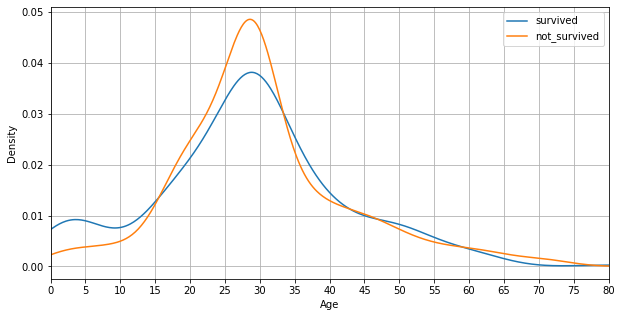

In [52]:
# Survivers by Age
survive_chance_by('Age', np.arange(0, 81, 5), (0, 80))

<p>By curves intersection points we can separate 4 age groups:</p>
<ol>
    <li>0-16 years old have higher survivability chance</li>
    <li>16-33 years old low chance</li>
    <li>33-43 years old better chance</li>
    <li>For the rest the chances are almost equal</li>
</ol>

In [53]:
new_df['Age_group'] = pd.cut(x=new_df.Age, labels=[4, 1, 3, 2],
                         bins=[-1, 16, 33, 43, new_df.Age.max()]).astype('float')

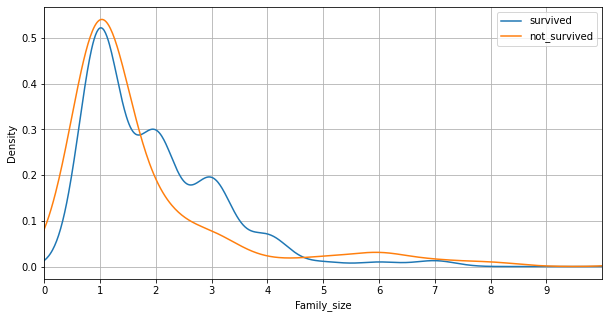

In [54]:
# Survivers by Family_size
survive_chance_by('Family_size', np.arange(0, 10, 1), (0, 10))

<p>Here we can separate 3 groups:<p>
<ol>
    <li>Single persons had lower chance to survive</li>
    <li>2-4 members families had higher chances, as they had some priority to safe-boats with 1 or 2 children with them</li>
    <li>5 and more members families had almost equal chances of survival</li>
</ol>

In [55]:
#Create Family_group feature
new_df['Family_group'] = pd.cut(x=new_df.Family_size, labels=[1, 3, 2], 
                            bins=[-1, 1, 4, new_df.Family_size.max()]).astype('float')

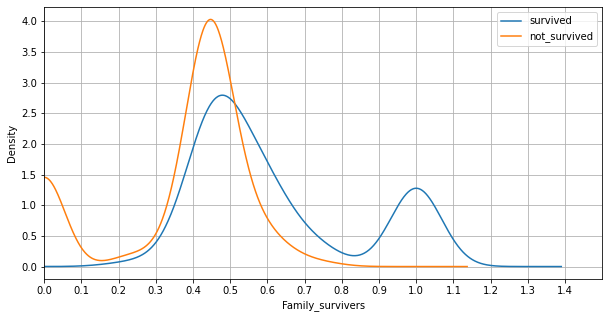

In [56]:
# Survivers by Family_survivers
survive_chance_by('Family_survivers', np.arange(0, 1.5, 0.1), (0, 1.5))

By curves intersection points we can separate 4 family groups with different chance to survive

In [57]:
# Create Lucky_family feature
new_df['Lucky_family'] = pd.cut(x=new_df.Family_survivers, labels=[2, 3, 1, 4],
                            bins=[-1, 0.22, 0.35, 0.49, new_df.Family_survivers.max()]).astype('float')

Let's Standardized our value

In [58]:
# Apply np.log to normalize the skewed right Price
new_df.Price = new_df.Price.apply(np.log1p)

# Standardize 
std_scaler = StandardScaler()

df_scaled = std_scaler.fit_transform(new_df)
new_df = pd.DataFrame(df_scaled, columns=new_df.columns)

In [59]:
# Drop features not used for modeling
cols_to_drop = ['Family_survivers', 'SibSp', 'Parch', 'Family_size']
new_df = new_df.drop(cols_to_drop, axis=1)

#### 3.4.3 Splitting Test and Train Data 

In [60]:
X = new_df[:X_max_index]
test_df = new_df[X_max_index:]

#### 3.4.4 Processed Data Correlation

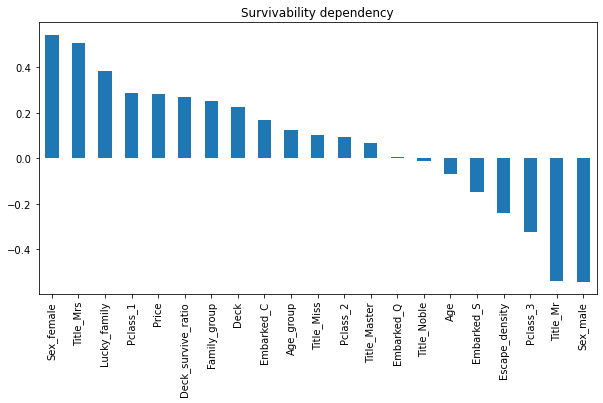

In [61]:
# Concatenate into a full dataset
new_df = pd.concat([X, y], axis=1)

correlation = new_df.corr()['Survived'].sort_values(ascending=False)

# Correlation graph
correlation[1:].plot(kind='bar', figsize=(10,5), title='Survivability dependency')
plt.show()

##### Conclusion :
* `Females` and `Mrs` had the more chances of survival. Women and children first !!!
* `Pclass1` and `Price` has the positive correlation. So priority was given to rich persons also.

*The ground truth is that on the Titanic it is better to not be an usual single adult male on a lower deck and embarked from Southampton with a cheap ticket price.*

## 4. Model Selection

### 4.1 Create an Instance of the model 

In [62]:
# Define model
cat_model = CatBoostClassifier(thread_count=-1, verbose=False)
rf_model = RandomForestClassifier(n_estimators= 200,max_depth=5, n_jobs=2, random_state=123)
lr_model = LogisticRegression(penalty = 'l2', random_state=123, max_iter = 1000)

### 4.2 Feature Selection

**CatBoost Classifier**

In [63]:
# Define and fit feature selector
sfs = SequentialFeatureSelector(cat_model, 
                                scoring='accuracy', 
                                direction = 'backward')
sfs.fit(X, y)

# List of the final features to be used for submission modeling
final_features = list(sfs.get_feature_names_out())
final_features

['Pclass_1',
 'Pclass_3',
 'Sex_male',
 'Title_Mr',
 'Age',
 'Price',
 'Deck_survive_ratio',
 'Age_group',
 'Family_group',
 'Lucky_family']

In [64]:
#Uncomment the code below for faster feature selection as the output of the above code is time consuming and will give you the same feature importances.

#cat_final_feature =  ['Pclass_1', 'Pclass_3', 'Sex_female', 'Title_Mr','Title_Mrs', 'Price', 'Deck_survive_ratio', 'Age_group', 'Family_group', 'Lucky_family']

#Loading the training and testing features
X_train_cat = X[final_features]
X_test_cat = test_df[final_features]

Let's verify that **Random Forest** also have the same feature selection

In [65]:

# Define and fit feature selector
sfs = SequentialFeatureSelector(rf_model, 
                                scoring='accuracy', 
                                direction = 'backward')
sfs.fit(X, y)

# List of the final features to be used for submission modeling
rf_final_features = list(sfs.get_feature_names_out())
print(rf_final_features)

['Pclass_2', 'Pclass_3', 'Sex_female', 'Sex_male', 'Embarked_S', 'Title_Master', 'Title_Miss', 'Title_Mrs', 'Deck_survive_ratio', 'Lucky_family']


In [66]:
#Uncomment the code below for faster feature selection as the output of the above code will give you the same feature importances

# rf_final_feature =  ['Pclass_2','Pclass_3', 'Sex_female','Sex_male', 'Embarked_S','Title_Master','Title_Miss','Title_Mrs', 'Deck_survive_ratio','Lucky_family']

#Loading the training & testing features
X_train_rf = X[rf_final_features]
X_test_rf = test_df[rf_final_features]

Few findings:
* We can see that in Random Forest classifier we got multiple new features for our training.

Now Let's Check for **Logistic Regression** Classifier

In [67]:
# Define and fit feature selector
sfs = SequentialFeatureSelector(lr_model, 
                                scoring='accuracy', 
                                direction = 'backward')
sfs.fit(X, y)

# List of the final features to be used for submission modeling
lr_final_features = list(sfs.get_feature_names_out())
lr_final_features

['Pclass_1',
 'Pclass_2',
 'Sex_male',
 'Embarked_Q',
 'Embarked_S',
 'Title_Master',
 'Title_Miss',
 'Age',
 'Deck',
 'Lucky_family']

In [68]:
#Uncomment the code below for faster feature selection as the output of the above code will give you the same feature importances.

# lr_final_feature =  ['Pclass_1','Pclass_2', 'Sex_male', 'Embarked_Q','Embarked_S','Title_Master','Title_Miss', 'Age', 'Deck', 'Lucky_family']

#Loading the training features and data to X_train_lr
X_train_lr = X[lr_final_features]
X_test_lr = test_df[lr_final_features]

Few findings:

* We can see that in Logistic Regression classifier we got some new features as well for our training.
* We got few of the similar feature interchangeably in our every classifier respectively, while `Lucky Family` and `Sex Male` was remain constant in every classifier.

### 4.3 Hyperparameter Tuning

* We are using `GridSearchCV` for hyper-parameter tuning.
* First we will search the best score and best parameter for every classifier model.
* Then we will select the best model after comparing the scores of the all model.

#### 4.3.1 CatBoostClassifier 

In [69]:
# Define model
cat_model = CatBoostClassifier()


# Define parameters' grid
grid = {'verbose': [False],
         'thread_count': [-1],
         'depth': [3, 4, 5, 6],
         'iterations': [500, 1000, 2000, 3000],
         'learning_rate': [0.0001, 0.001, 0.01]}

# Define GridSearchCV
grid_cat = GridSearchCV(estimator=cat_model, param_grid=grid, cv=3, n_jobs=-1)
grid_cat.fit(X_train_cat, y)

params = grid_cat.best_params_

print('\n Best Score:\n', grid_cat.best_score_)
print('\n Best Parameters:\n', params)


 Best Score:
 0.8451178451178452

 Best Parameters:
 {'depth': 3, 'iterations': 1000, 'learning_rate': 0.01, 'thread_count': -1, 'verbose': False}


We got score of `0.845` in this classifier. It's pretty good !!!

#### 4.3.2 RandomForestClassifier

In [70]:
# Define model
rf_model = RandomForestClassifier()


# Define parameters' grid
param_grid = {'n_estimators': [2*n+1 for n in range(20)],
             'max_depth' : [2*n+1 for n in range(10) ],
             'max_features':["auto", "sqrt", "log2"]}

#Grid Search Hyperparameter tuning
search = GridSearchCV(estimator=rf_model, param_grid=param_grid,scoring='accuracy')
search.fit(X_train_rf, y)


C:\Users\lenovo\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\lenovo\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\lenovo\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value f

C:\Users\lenovo\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\lenovo\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\lenovo\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value f

C:\Users\lenovo\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\lenovo\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\lenovo\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value f

C:\Users\lenovo\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\lenovo\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\lenovo\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value f

C:\Users\lenovo\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\lenovo\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\lenovo\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value f

C:\Users\lenovo\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\lenovo\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\lenovo\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value f

C:\Users\lenovo\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\lenovo\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\lenovo\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value f

C:\Users\lenovo\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\lenovo\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\lenovo\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value f

C:\Users\lenovo\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\lenovo\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\lenovo\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value f

C:\Users\lenovo\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\lenovo\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\lenovo\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value f

C:\Users\lenovo\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\lenovo\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\lenovo\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value f

C:\Users\lenovo\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\lenovo\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\lenovo\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value f

C:\Users\lenovo\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\lenovo\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\lenovo\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value f

C:\Users\lenovo\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\lenovo\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\lenovo\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value f

C:\Users\lenovo\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\lenovo\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\lenovo\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value f

C:\Users\lenovo\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\lenovo\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\lenovo\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value f

C:\Users\lenovo\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\lenovo\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\lenovo\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value f

C:\Users\lenovo\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\lenovo\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\lenovo\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value f

C:\Users\lenovo\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\lenovo\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\lenovo\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value f

C:\Users\lenovo\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\lenovo\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\lenovo\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value f

C:\Users\lenovo\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\lenovo\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\lenovo\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value f

C:\Users\lenovo\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\lenovo\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\lenovo\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value f

C:\Users\lenovo\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\lenovo\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\lenovo\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value f

C:\Users\lenovo\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\lenovo\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\lenovo\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value f

C:\Users\lenovo\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\lenovo\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\lenovo\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value f

C:\Users\lenovo\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\lenovo\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\lenovo\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value f

C:\Users\lenovo\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\lenovo\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\lenovo\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value f

C:\Users\lenovo\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\lenovo\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\lenovo\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value f

C:\Users\lenovo\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\lenovo\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\lenovo\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value f

C:\Users\lenovo\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\lenovo\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\lenovo\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value f

C:\Users\lenovo\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\lenovo\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\lenovo\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value f

C:\Users\lenovo\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\lenovo\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\lenovo\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value f

C:\Users\lenovo\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\lenovo\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\lenovo\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value f

C:\Users\lenovo\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\lenovo\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\lenovo\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value f

C:\Users\lenovo\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\lenovo\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\lenovo\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value f

C:\Users\lenovo\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\lenovo\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\lenovo\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value f

C:\Users\lenovo\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\lenovo\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\lenovo\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value f

C:\Users\lenovo\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\lenovo\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\lenovo\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value f

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'max_depth': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21,
                                          23, 25, 27, 29, 31, 33, 35, 37, 39]},
             scoring='accuracy')

In [71]:
#we will print the best score and parameters here for clearer view
print('\n Best Score:\n', search.best_score_)
print('\n Best Parameters:\n', search.best_params_)


 Best Score:
 0.8507375557089951

 Best Parameters:
 {'max_depth': 5, 'max_features': 'log2', 'n_estimators': 21}


We got a bit of improvement in our score in Random Forest Classifier `0.847` compared to CatBoost Classifier `0.845`.

#### 4.3.3 LogisticRegression

In [72]:
lr_model.get_params().keys()

dict_keys(['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'l1_ratio', 'max_iter', 'multi_class', 'n_jobs', 'penalty', 'random_state', 'solver', 'tol', 'verbose', 'warm_start'])

In [73]:
# Define model
lr_model = LogisticRegression( max_iter = 1000)


# Define parameters' grid
param_grid = {'multi_class': ["auto", "ovr", "multinomial"],
              'solver' : ["lbfgs", "liblinear", "newton-cg", "newton-cholesky", "sag", "saga" ],
              'penalty': ["l1", "l2", "elasticnet", "None"],
              'l1_ratio': [0, 0.5,1]},

#Grid Search Hyperparameter tuning
lr_search = GridSearchCV(estimator=lr_model, param_grid=param_grid, scoring='accuracy')
lr_search.fit(X_train_lr, y)


GridSearchCV(estimator=LogisticRegression(max_iter=1000),
             param_grid=({'l1_ratio': [0, 0.5, 1],
                          'multi_class': ['auto', 'ovr', 'multinomial'],
                          'penalty': ['l1', 'l2', 'elasticnet', 'None'],
                          'solver': ['lbfgs', 'liblinear', 'newton-cg',
                                     'newton-cholesky', 'sag', 'saga']},),
             scoring='accuracy')

In [74]:
#we will print the best score and parameters here for clearer view
print('\n Best Score:\n', lr_search.best_score_)
print('\n Best Parameters:\n', lr_search.best_params_)


 Best Score:
 0.8114556525014123

 Best Parameters:
 {'l1_ratio': 0, 'multi_class': 'auto', 'penalty': 'l1', 'solver': 'liblinear'}


Logistic Regression Classifier got the lowest score with `0.811` compared to CatBoost Classifier and Random Forest Classifier

Now let's compare our Score

In [75]:

best_score = {'Classifiers': ['Logistic Regression Classifier', 'CatBoost Classifier', 'Random Forrest Classifier'],
        'Best Score': [lr_search.best_score_, grid_cat.best_score_, search.best_score_]}

score_df = pd.DataFrame(best_score)
score_df

,Classifiers,Best Score
0,Logistic Regression Classifier,0.811456
1,CatBoost Classifier,0.845118
2,Random Forrest Classifier,0.850738


Random Forest Classifier got the best score. We will select the Random Forest Classifier and CatBoost Classifier to predict the survivalist using our test data. Now we are going to build our final model !!!

### 4.4 Final Model

* We will select the final model for prediction after checking the max value of `cross_val_score` and individual feature importances in our respective classifier.


#### 4.4.1 Fitting the Model

*CatBoostClassifier*

In [76]:
# Define and fit the model
cat_model = CatBoostClassifier(**params)
cat_model.fit(X[final_features], y)

# Check accuracy and features importance
cat_rmses = cross_val_score(cat_model, X[final_features], y, cv=5)

print(pd.Series(cat_rmses).describe())
print('\n', cat_model.get_feature_importance(prettified=True))


count    5.000000
mean     0.821618
std      0.042178
min      0.759777
25%      0.803371
50%      0.831461
75%      0.842697
max      0.870787
dtype: float64

            Feature Id  Importances
0        Lucky_family    36.638855
1            Sex_male    22.966685
2            Title_Mr    10.281616
3                 Age     7.908306
4        Family_group     5.957846
5               Price     5.028250
6            Pclass_3     4.483750
7  Deck_survive_ratio     3.516477
8            Pclass_1     1.661322
9           Age_group     1.556892


*RandomForestClassifier*

In [77]:
#For selecting the max features
M_features = X_train_rf.shape[1]
print(M_features)
max_feature = round(np.sqrt(M_features))-1
print(max_feature)

10
2


In [78]:
#Fitting the model
final_model = RandomForestClassifier(n_estimators= 39,random_state = 123, max_depth= 5, max_features=max_feature)
final_model.fit(X_train_rf,y)

RandomForestClassifier(max_depth=5, max_features=2, n_estimators=39,
                       random_state=123)

In [79]:
# Check accuracy and features importance
rf_rmses = cross_val_score(final_model, X_train_rf, y, cv=5)

importances = final_model.feature_importances_
feature_importances = pd.DataFrame({'feature': X_train_rf.columns, 'importance': importances})

print(pd.Series(rf_rmses).describe())
print(feature_importances)

count    5.000000
mean     0.843983
std      0.022000
min      0.808989
25%      0.837079
50%      0.853933
75%      0.854749
max      0.865169
dtype: float64
              feature  importance
0            Pclass_2    0.027535
1            Pclass_3    0.068293
2          Sex_female    0.198117
3            Sex_male    0.229946
4          Embarked_S    0.019544
5        Title_Master    0.042664
6          Title_Miss    0.006265
7           Title_Mrs    0.105453
8  Deck_survive_ratio    0.084131
9        Lucky_family    0.218052


Findings:
*  We found that `CatBoost` Classifier have better cross-val_score and feature importances compared to `RandomForest` Classifier.
* We will choose `CatBoost` Classifier for predicting and saving the output.

#### 4.4.2 Model Prediction

*CatBoostClassifier*

In [80]:
# Make predictions which we will submit.
cat_preds = cat_model.predict(X_test_cat)

#### 4.4.3 Saving Output

In [82]:
# Save predictions in the format used for competition scoring
output = pd.DataFrame({'PassengerId': test_pass_id,
                       'Survived': cat_preds})
output.to_csv('submission.csv', index=False)

#### 4.4.4 Reading Output

In [83]:
df = pd.read_csv('submission.csv')
df.head(10)

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
5,897,0
6,898,1
7,899,0
8,900,1
9,901,0


## 5. Conclusion

We did a deep analysis on this data and than we tried different classification models to predict the outcomes. The results will be helpful for the ship voyager as they can take precautions in future ship disasters like Titanic(Which we don't want to happened anyway ). 
Our few Findings for survival lists were:
* Females, children, and family sizes of 2-4 are more likely to survive.
* Passenger from Top `Deck_level` and passengers from High `Pclass` who bought expensive ticket are also more likely to survive.
* Males passenger, passenger from Lower `Deck_level` , and Passenger from lower `Pclass` with cheap ticket prices did not had the privilege to survive in the Titanic Disaster. Hope we can save them in future disasters.
* `RandomForest` Classifier surprisingly performed better than `CatBoost` Classifier and `LogisticRegression` Classifier during model selection.
* But `CatBoost` had the better `cross_val_score` and `feature importance` compared to  `RandomForest` Classifier during Fitting the Model.
* We selected `CatBoost` Classifier and build the final model.
* We saved the output of prediction along with the passenger's id respectively in `subimission.csv` file.